# Market quota game

## Simulating SNP500 data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

In [5]:
r = 0.01
s = 0.1474
S0 = 100
m = r - 0.5*s*s
dt = 1/365/24/60/60/100 #10 ms
n = 100*60*10

In [6]:
def geom_brownian_motion(S0, m, s, n, dt):
    logret = np.random.normal(m * dt, s * np.sqrt(dt), size=int(n))
    ret = np.exp(logret.cumsum())
    price = S0*ret
    return price

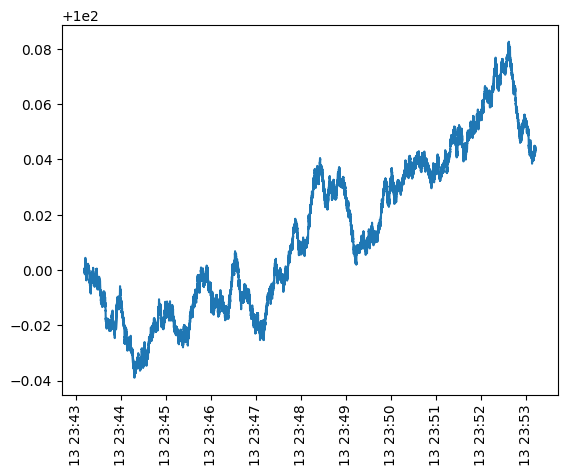

In [53]:
plt.figure()
plt.plot(pd.date_range(start=datetime.now(), periods=n, freq="10ms"), geom_brownian_motion(S0, m, s, n, dt))
plt.xticks(rotation=90)
plt.show()